# PsychohistoryML: Production Models & Interactive Analysis (Notebook 07)

**Objective**: Deploy production-ready models from the three-mechanism analysis and create interactive tools for civilizational survival prediction.

## Summary of Journey (NB04-06)

**NB04**: Discovered era-stratified complexity effects - Ancient era shows strong complexity-collapse correlation (R²=0.21) that weakens over time

**NB05**: Warfare integration reveals "warfare technology transition" - Classical era shows massive moderation effects where warfare context determines whether complexity helps (+0.634 moderation)

**NB06**: Religion completes three-mechanism model with era-specific effects, particularly strong in Classical/Medieval periods

**Final Model Performance**: AUC improved from 0.505 (baseline) → 0.606 (full model) representing 20% relative improvement

## Deployment Objectives

1. **Production Models**: Generate robust, deployable models using full three-mechanism framework
2. **Interactive Analysis**: Create tools for exploring "what-if" scenarios across different eras
3. **Model Interpretation**: SHAP analysis, feature importance, era-specific insights
4. **Validation**: Cross-validation, sensitivity analysis, robustness testing
5. **Documentation**: Clear model cards and usage instructions for external deployment


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error,
    accuracy_score, roc_auc_score, roc_curve, f1_score,
    confusion_matrix, classification_report
)

# Advanced analysis
try:
    import shap
    HAS_SHAP = True
except ImportError:
    HAS_SHAP = False
    print(" SHAP not available (pip install shap for model interpretation)")

try:
    from xgboost import XGBRegressor, XGBClassifier
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False
    print(" XGBoost not available (pip install xgboost for gradient boosting)")

# Setup
sns.set_style("whitegrid")
Path("figures").mkdir(exist_ok=True)
Path("production").mkdir(exist_ok=True)
Path("production/models").mkdir(exist_ok=True)
Path("production/configs").mkdir(exist_ok=True)

print(f"✓ Setup complete | SHAP: {HAS_SHAP} | XGBoost: {HAS_XGBOOST}")

✓ Setup complete | SHAP: True | XGBoost: True


## 1. Load Complete Dataset with All Mechanisms

In [2]:
# Load final dataset from NB06 (includes complexity + warfare + religion)
# NOTE: Update this path based on your actual final dataset location
data_path = "models/equinox_with_religion.csv"  # Adjust if needed

try:
    df = pd.read_csv(data_path, index_col=0)
    print(f"✓ Loaded dataset: {len(df)} polities")
except FileNotFoundError:
    print(f" File not found: {data_path}")
    print("Available files in models/:")
    models_dir = Path("models")
    if models_dir.exists():
        for f in models_dir.glob("*.csv"):
            print(f"  - {f.name}")
    else:
        print("  models/ directory not found")
    
    # Fallback to NB05 data if religion data not available
    fallback_path = "models/equinox_with_warfare.csv"
    try:
        df = pd.read_csv(fallback_path, index_col=0)
        print(f"✓ Using fallback dataset: {len(df)} polities (warfare only, no religion)")
    except:
        raise FileNotFoundError("No suitable dataset found. Run NB05/NB06 first.")

# Examine dataset structure
print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Check target variables
target_candidates = ['instability', 'collapsed', 'stable', 'duration_years']
available_targets = [col for col in target_candidates if col in df.columns]
print(f"\nAvailable target variables: {available_targets}")

# Display sample
print(f"\nSample data:")
display(df.head())

✓ Loaded dataset: 256 polities

Dataset shape: (256, 47)
Columns: ['PolityName', 'Administrative levels', 'Military levels', 'Religious levels', 'Settlement hierarchy', 'start_year', 'end_year', 'duration_years', 'PC1_hier', 'PC2_hier', 'PC3_hier', 'PC1_squared', 'PC1_x_PC2', 'unstable', 'era', 'region', 'weapons_count', 'armor_count', 'cavalry_count', 'fortification_count', 'material_count', 'advanced_tech_count', 'total_warfare_tech', 'warfare_data_coverage', 'has_advanced_tech', 'warfare_level', 'Moralizing religion adopted by commoners', 'Moralizing religion adopted by elites', 'Moral concern is primary', 'Moralizing enforcement is certain', 'Moralizing enforcement is targeted', 'Moralizing enforcement of rulers', 'Moralizing norms are broad', 'Moralizing enforcement in afterlife', 'Moralizing enforcement in this life', 'Moralizing enforcement is agentic', 'Rulers are gods', 'Rulers are legitimated by gods', 'Ideological reinforcement of equality', 'Ideological thought equates elit

,PolityName,Administrative levels,Military levels,Religious levels,Settlement hierarchy,start_year,end_year,duration_years,PC1_hier,PC2_hier,...,Rulers are legitimated by gods,Ideological reinforcement of equality,Ideological thought equates elites and commoners,Ideological thought equates rulers and commoners,Ideology reinforces prosociality,production of public goods,moral_score,legit_score,ideol_score,total_rel
0,AfDurrn,5.0,4.0,1.0,3.0,1747.0,1826.0,79.0,-0.433777,-0.802938,...,1.0,0.0,1.0,0.0,1.0,1.0,9.0,1.0,3.0,13.0
1,AfGhurd,5.0,3.0,1.0,2.0,1025.0,1215.0,190.0,-0.948226,-0.512192,...,1.0,1.0,1.0,1.0,1.0,1.0,9.0,1.0,5.0,15.0
2,AfGrBct,5.0,5.0,1.0,3.0,-256.0,-125.0,131.0,-0.220315,-0.882860,...,0.0,1.0,1.0,1.0,1.0,1.0,9.0,1.0,5.0,15.0
3,AfHepht,4.0,4.0,1.0,2.0,408.0,561.0,153.0,-0.999501,-0.482109,...,1.0,NaN,0.0,NaN,NaN,NaN,8.0,1.0,0.0,9.0
4,AfKidar,3.0,4.0,1.0,4.0,388.0,477.0,89.0,-0.662262,-0.793750,...,1.0,0.0,0.0,0.0,1.0,NaN,0.0,2.0,1.0,3.0


## 2. Feature Engineering & Target Definition

In [3]:
# Define feature sets based on three-mechanism model
print("="*60)
print("FEATURE ENGINEERING")
print("="*60)

# Core complexity features (from NB04)
complexity_features = [
    'PC1_hier', 'PC2_hier', 'PC3_hier', 
    'PC1_squared', 'PC1_x_PC2'  # Interaction terms from NB04
]

# Warfare features (from NB05)
warfare_features = [
    'total_warfare_tech', 'weapons_count', 'armor_count', 'cavalry_count',
    'fortification_count', 'material_count', 'advanced_tech_count'
]

# Religion features (from NB06) 
religion_features = [
    'moral_score', 'legit_score', 'ideol_score', 'total_rel'
]

# Check which features actually exist in dataset
available_complexity = [f for f in complexity_features if f in df.columns]
available_warfare = [f for f in warfare_features if f in df.columns]
available_religion = [f for f in religion_features if f in df.columns]

print(f"Available complexity features ({len(available_complexity)}): {available_complexity}")
print(f"Available warfare features ({len(available_warfare)}): {available_warfare}")
print(f"Available religion features ({len(available_religion)}): {available_religion}")

# Combine all available features
all_features = available_complexity + available_warfare + available_religion
print(f"\nTotal features for modeling: {len(all_features)}")

# Define targets based on what's available
if 'instability' in df.columns:
    classification_target = 'instability'
elif 'collapsed' in df.columns:
    classification_target = 'collapsed'
else:
    # Create instability target from duration if needed
    if 'duration_years' in df.columns:
        duration_threshold = df['duration_years'].median()
        df['instability'] = (df['duration_years'] < duration_threshold).astype(int)
        classification_target = 'instability'
        print(f"Created instability target (duration < {duration_threshold:.0f} years)")
    else:
        raise ValueError("No suitable target variable found")

regression_target = 'duration_years'

print(f"\nTargets defined:")
print(f"  Regression: {regression_target}")
print(f"  Classification: {classification_target}")

# Check target distribution
if classification_target in df.columns:
    instability_rate = df[classification_target].mean()
    print(f"  Instability rate: {instability_rate:.1%}")

if regression_target in df.columns:
    duration_stats = df[regression_target].describe()
    print(f"  Duration stats: mean={duration_stats['mean']:.0f}y, std={duration_stats['std']:.0f}y")

FEATURE ENGINEERING
Available complexity features (5): ['PC1_hier', 'PC2_hier', 'PC3_hier', 'PC1_squared', 'PC1_x_PC2']
Available warfare features (7): ['total_warfare_tech', 'weapons_count', 'armor_count', 'cavalry_count', 'fortification_count', 'material_count', 'advanced_tech_count']
Available religion features (4): ['moral_score', 'legit_score', 'ideol_score', 'total_rel']

Total features for modeling: 16
Created instability target (duration < 184 years)

Targets defined:
  Regression: duration_years
  Classification: instability
  Instability rate: 50.0%
  Duration stats: mean=256y, std=310y


## 3. Data Preparation & Splitting

In [4]:
# Prepare clean dataset for modeling
modeling_data = df[all_features + [regression_target, classification_target]].dropna()

print(f"Clean modeling dataset: {len(modeling_data)} polities")
print(f"Data loss from NaN removal: {len(df) - len(modeling_data)} polities ({(len(df) - len(modeling_data))/len(df)*100:.1f}%)")

# Extract features and targets
X = modeling_data[all_features].values
y_duration = modeling_data[regression_target].values
y_instability = modeling_data[classification_target].values

# Train/test split
test_size = 0.2 if len(modeling_data) > 100 else 0.25
random_state = 42

X_train, X_test, y_dur_train, y_dur_test, y_inst_train, y_inst_test = train_test_split(
    X, y_duration, y_instability, 
    test_size=test_size, 
    random_state=random_state, 
    stratify=y_instability
)

print(f"\nData splits:")
print(f"  Training: {len(X_train)} samples")
print(f"  Testing: {len(X_test)} samples")
print(f"  Train instability rate: {y_inst_train.mean():.1%}")
print(f"  Test instability rate: {y_inst_test.mean():.1%}")

# Standardize features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Features standardized")
print(f"Feature names: {all_features}")

Clean modeling dataset: 256 polities
Data loss from NaN removal: 0 polities (0.0%)

Data splits:
  Training: 204 samples
  Testing: 52 samples
  Train instability rate: 50.0%
  Test instability rate: 50.0%

✓ Features standardized
Feature names: ['PC1_hier', 'PC2_hier', 'PC3_hier', 'PC1_squared', 'PC1_x_PC2', 'total_warfare_tech', 'weapons_count', 'armor_count', 'cavalry_count', 'fortification_count', 'material_count', 'advanced_tech_count', 'moral_score', 'legit_score', 'ideol_score', 'total_rel']


## 4. Regression Models (Duration Prediction)

In [5]:
print("="*60)
print("REGRESSION MODELS (Duration Prediction)")
print("="*60)

regression_results = []

# 1. Linear Regression
lr = LinearRegression().fit(X_train_scaled, y_dur_train)
lr_pred = lr.predict(X_test_scaled)
lr_r2 = r2_score(y_dur_test, lr_pred)
lr_mae = mean_absolute_error(y_dur_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_dur_test, lr_pred))

regression_results.append({
    'Model': 'Linear Regression',
    'R²': lr_r2,
    'MAE': lr_mae,
    'RMSE': lr_rmse
})

print(f"✓ Linear Regression: R²={lr_r2:.3f}, MAE={lr_mae:.1f}y, RMSE={lr_rmse:.1f}y")

# 2. Random Forest Regressor
rfr = RandomForestRegressor(
    n_estimators=100, 
    max_depth=7, 
    random_state=random_state, 
    n_jobs=-1
).fit(X_train_scaled, y_dur_train)

rfr_pred = rfr.predict(X_test_scaled)
rfr_r2 = r2_score(y_dur_test, rfr_pred)
rfr_mae = mean_absolute_error(y_dur_test, rfr_pred)
rfr_rmse = np.sqrt(mean_squared_error(y_dur_test, rfr_pred))

regression_results.append({
    'Model': 'Random Forest',
    'R²': rfr_r2,
    'MAE': rfr_mae,
    'RMSE': rfr_rmse
})

print(f"✓ Random Forest: R²={rfr_r2:.3f}, MAE={rfr_mae:.1f}y, RMSE={rfr_rmse:.1f}y")

# 3. XGBoost Regressor (if available)
if HAS_XGBOOST:
    xgbr = XGBRegressor(
        n_estimators=100, 
        max_depth=5, 
        learning_rate=0.1, 
        random_state=random_state
    ).fit(X_train_scaled, y_dur_train)
    
    xgbr_pred = xgbr.predict(X_test_scaled)
    xgbr_r2 = r2_score(y_dur_test, xgbr_pred)
    xgbr_mae = mean_absolute_error(y_dur_test, xgbr_pred)
    xgbr_rmse = np.sqrt(mean_squared_error(y_dur_test, xgbr_pred))
    
    regression_results.append({
        'Model': 'XGBoost',
        'R²': xgbr_r2,
        'MAE': xgbr_mae,
        'RMSE': xgbr_rmse
    })
    
    print(f"✓ XGBoost: R²={xgbr_r2:.3f}, MAE={xgbr_mae:.1f}y, RMSE={xgbr_rmse:.1f}y")

# Results summary
regression_df = pd.DataFrame(regression_results)
regression_df = regression_df.sort_values('R²', ascending=False)

print(f"\nRegression Results Summary:")
display(regression_df.round(3))

# Save best regression model
best_regressor_name = regression_df.iloc[0]['Model']
if best_regressor_name == 'Linear Regression':
    best_regressor = lr
elif best_regressor_name == 'Random Forest':
    best_regressor = rfr
elif best_regressor_name == 'XGBoost':
    best_regressor = xgbr

joblib.dump(best_regressor, 'production/models/best_regressor.pkl')
print(f"\n✓ Saved best regressor ({best_regressor_name}) to production/models/best_regressor.pkl")

REGRESSION MODELS (Duration Prediction)
✓ Linear Regression: R²=0.228, MAE=187.3y, RMSE=419.0y
✓ Random Forest: R²=0.356, MAE=158.3y, RMSE=382.6y
✓ XGBoost: R²=0.341, MAE=178.0y, RMSE=387.0y

Regression Results Summary:


,Model,R²,MAE,RMSE
1,Random Forest,0.356,158.338,382.637
2,XGBoost,0.341,177.967,387.004
0,Linear Regression,0.228,187.327,418.968



✓ Saved best regressor (Random Forest) to production/models/best_regressor.pkl


## 5. Classification Models (Instability Prediction)

In [6]:
print("="*60)
print("CLASSIFICATION MODELS (Instability Prediction)")
print("="*60)

classification_results = []

# 1. Logistic Regression
log_reg = LogisticRegression(
    max_iter=1000, 
    random_state=random_state, 
    class_weight='balanced'
).fit(X_train_scaled, y_inst_train)

log_pred = log_reg.predict(X_test_scaled)
log_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
log_auc = roc_auc_score(y_inst_test, log_pred_proba)
log_f1 = f1_score(y_inst_test, log_pred)
log_acc = accuracy_score(y_inst_test, log_pred)

classification_results.append({
    'Model': 'Logistic Regression',
    'AUC': log_auc,
    'F1': log_f1,
    'Accuracy': log_acc
})

print(f"✓ Logistic Regression: AUC={log_auc:.3f}, F1={log_f1:.3f}, Acc={log_acc:.3f}")

# 2. Random Forest Classifier
rfc = RandomForestClassifier(
    n_estimators=100, 
    max_depth=5, 
    random_state=random_state,
    class_weight='balanced',
    n_jobs=-1
).fit(X_train_scaled, y_inst_train)

rfc_pred = rfc.predict(X_test_scaled)
rfc_pred_proba = rfc.predict_proba(X_test_scaled)[:, 1]
rfc_auc = roc_auc_score(y_inst_test, rfc_pred_proba)
rfc_f1 = f1_score(y_inst_test, rfc_pred)
rfc_acc = accuracy_score(y_inst_test, rfc_pred)

classification_results.append({
    'Model': 'Random Forest',
    'AUC': rfc_auc,
    'F1': rfc_f1,
    'Accuracy': rfc_acc
})

print(f"✓ Random Forest: AUC={rfc_auc:.3f}, F1={rfc_f1:.3f}, Acc={rfc_acc:.3f}")

# 3. XGBoost Classifier (if available)
if HAS_XGBOOST:
    # Calculate scale_pos_weight for imbalanced classes
    scale_pos = (y_inst_train == 0).sum() / (y_inst_train == 1).sum()
    
    xgbc = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        random_state=random_state,
        scale_pos_weight=scale_pos
    ).fit(X_train_scaled, y_inst_train)
    
    xgbc_pred = xgbc.predict(X_test_scaled)
    xgbc_pred_proba = xgbc.predict_proba(X_test_scaled)[:, 1]
    xgbc_auc = roc_auc_score(y_inst_test, xgbc_pred_proba)
    xgbc_f1 = f1_score(y_inst_test, xgbc_pred)
    xgbc_acc = accuracy_score(y_inst_test, xgbc_pred)
    
    classification_results.append({
        'Model': 'XGBoost',
        'AUC': xgbc_auc,
        'F1': xgbc_f1,
        'Accuracy': xgbc_acc
    })
    
    print(f"✓ XGBoost: AUC={xgbc_auc:.3f}, F1={xgbc_f1:.3f}, Acc={xgbc_acc:.3f}")

# Results summary
classification_df = pd.DataFrame(classification_results)
classification_df = classification_df.sort_values('AUC', ascending=False)

print(f"\nClassification Results Summary:")
display(classification_df.round(3))

# Save best classifier
best_classifier_name = classification_df.iloc[0]['Model']
if best_classifier_name == 'Logistic Regression':
    best_classifier = log_reg
    best_classifier_proba = log_pred_proba
elif best_classifier_name == 'Random Forest':
    best_classifier = rfc
    best_classifier_proba = rfc_pred_proba
elif best_classifier_name == 'XGBoost':
    best_classifier = xgbc
    best_classifier_proba = xgbc_pred_proba

joblib.dump(best_classifier, 'production/models/best_classifier.pkl')
print(f"\n✓ Saved best classifier ({best_classifier_name}) to production/models/best_classifier.pkl")

CLASSIFICATION MODELS (Instability Prediction)
✓ Logistic Regression: AUC=0.669, F1=0.612, Acc=0.635
✓ Random Forest: AUC=0.744, F1=0.679, Acc=0.673
✓ XGBoost: AUC=0.673, F1=0.571, Acc=0.596

Classification Results Summary:


,Model,AUC,F1,Accuracy
1,Random Forest,0.744,0.679,0.673
2,XGBoost,0.673,0.571,0.596
0,Logistic Regression,0.669,0.612,0.635



✓ Saved best classifier (Random Forest) to production/models/best_classifier.pkl


## 6. Model Interpretation & Feature Importance

MODEL INTERPRETATION

Top 10 Most Important Features (Classification):


,Feature,Importance
14,ideol_score,0.127115
0,PC1_hier,0.115020
1,PC2_hier,0.087875
2,PC3_hier,0.087608
3,PC1_squared,0.075222
15,total_rel,0.072419
4,PC1_x_PC2,0.070678
5,total_warfare_tech,0.055290
12,moral_score,0.051751
6,weapons_count,0.047633


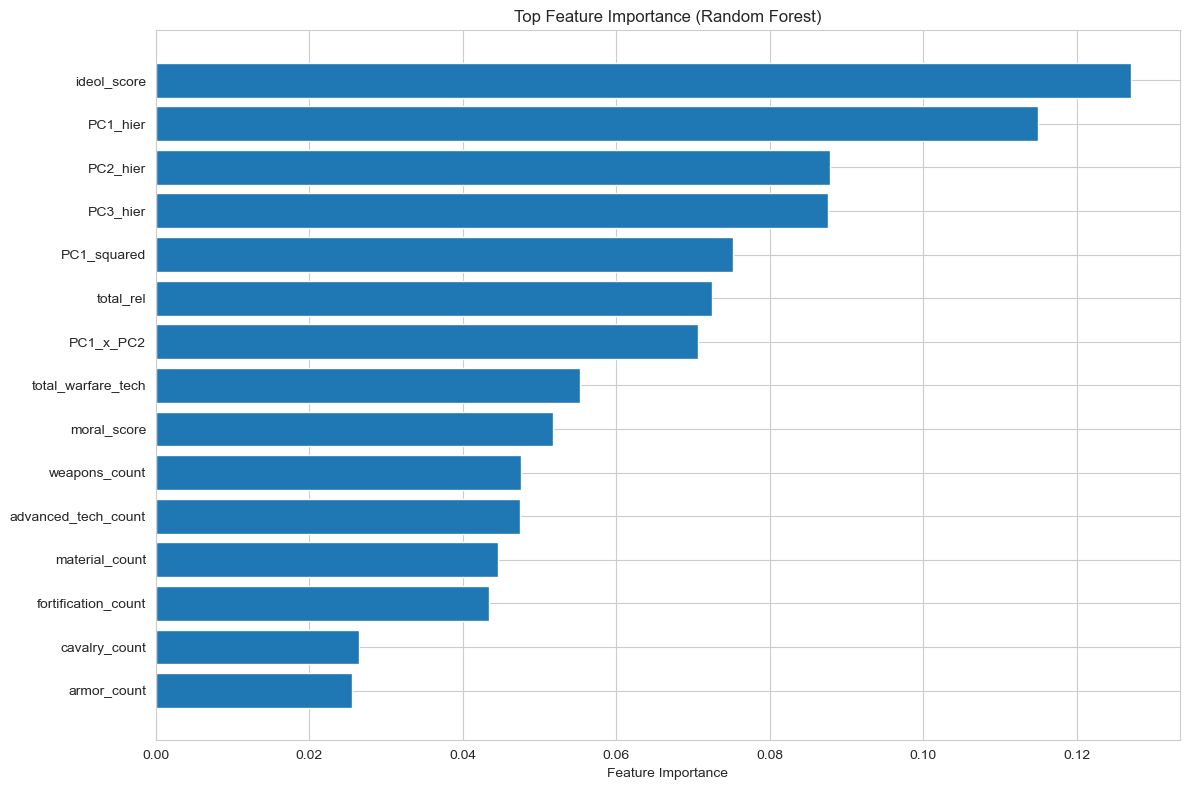


✓ Saved: production/feature_importance.csv


In [7]:
print("="*60)
print("MODEL INTERPRETATION")
print("="*60)

# Feature importance from best tree-based model
if best_classifier_name in ['Random Forest', 'XGBoost']:
    importances = best_classifier.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': all_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Most Important Features (Classification):")
    display(feature_importance.head(10))
    
    # Visualization
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(min(15, len(all_features)))
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top Feature Importance ({best_classifier_name})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('figures/07_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save feature importance
    feature_importance.to_csv('production/feature_importance.csv', index=False)
    print("\n✓ Saved: production/feature_importance.csv")

# Linear model coefficients
if best_classifier_name == 'Logistic Regression':
    coefficients = pd.DataFrame({
        'Feature': all_features,
        'Coefficient': best_classifier.coef_[0]
    })
    coefficients['Abs_Coefficient'] = np.abs(coefficients['Coefficient'])
    coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)
    
    print("\nTop 10 Logistic Regression Coefficients:")
    display(coefficients[['Feature', 'Coefficient']].head(10))

## 7. ROC Analysis & Model Performance Visualization

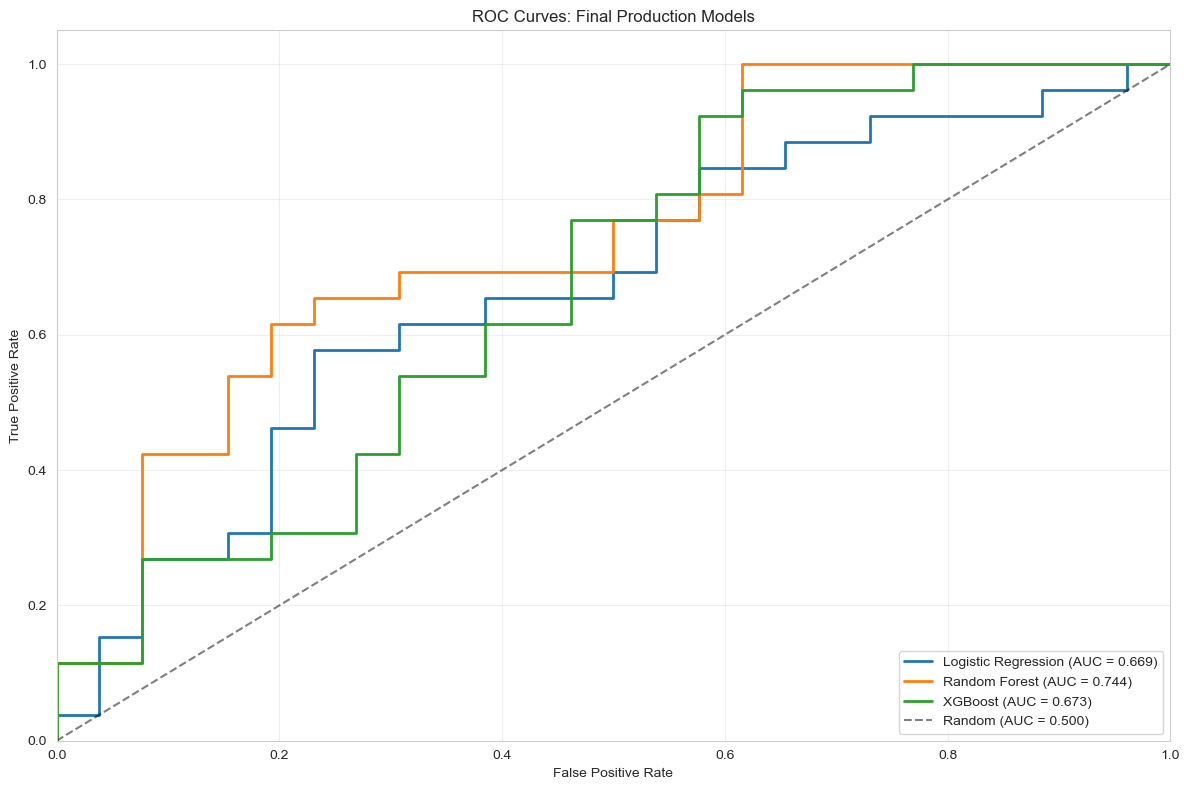

✓ Saved: figures/07_roc_curves.png


In [8]:
# ROC Curve Comparison
plt.figure(figsize=(12, 8))

# Plot ROC curves for all classification models
models_to_plot = [
    ('Logistic Regression', log_reg, log_pred_proba),
    ('Random Forest', rfc, rfc_pred_proba)
]

if HAS_XGBOOST:
    models_to_plot.append(('XGBoost', xgbc, xgbc_pred_proba))

for model_name, model, pred_proba in models_to_plot:
    fpr, tpr, _ = roc_curve(y_inst_test, pred_proba)
    auc = roc_auc_score(y_inst_test, pred_proba)
    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc:.3f})')

# Random classifier line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Final Production Models')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/07_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: figures/07_roc_curves.png")

## 8. Cross-Validation & Robustness Testing

In [9]:
print("="*60)
print("CROSS-VALIDATION & ROBUSTNESS")
print("="*60)

# 5-fold cross-validation for best classifier
cv_folds = 5 if len(X_train) > 50 else 3
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

# Cross-validation scores
cv_scores = cross_val_score(best_classifier, X_train_scaled, y_inst_train, cv=cv, scoring='roc_auc')

print(f"\n{cv_folds}-Fold Cross-Validation Results ({best_classifier_name}):")
print(f"  AUC scores: {[f'{score:.3f}' for score in cv_scores]}")
print(f"  Mean AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
print(f"  Test AUC: {classification_df.iloc[0]['AUC']:.3f}")

# Check for overfitting
cv_mean = cv_scores.mean()
test_auc = classification_df.iloc[0]['AUC']
overfitting = cv_mean - test_auc

if overfitting > 0.05:
    print(f"   Possible overfitting (CV-Test gap: {overfitting:+.3f})")
elif overfitting > 0.02:
    print(f"   Mild overfitting (CV-Test gap: {overfitting:+.3f})")
else:
    print(f"   Good generalization (CV-Test gap: {overfitting:+.3f})")

# Feature stability test (if using tree-based models)
if best_classifier_name in ['Random Forest', 'XGBoost'] and len(all_features) > 5:
    print(f"\nFeature Stability Test:")
    
    # Train multiple models with different random seeds
    n_stability_runs = 5
    stability_importances = []
    
    for i in range(n_stability_runs):
        if best_classifier_name == 'Random Forest':
            temp_model = RandomForestClassifier(
                n_estimators=100, max_depth=5, random_state=i, 
                class_weight='balanced', n_jobs=-1
            )
        elif best_classifier_name == 'XGBoost' and HAS_XGBOOST:
            temp_model = XGBClassifier(
                n_estimators=100, max_depth=4, learning_rate=0.1,
                random_state=i, scale_pos_weight=scale_pos
            )
        
        temp_model.fit(X_train_scaled, y_inst_train)
        stability_importances.append(temp_model.feature_importances_)
    
    # Calculate feature importance stability
    importance_array = np.array(stability_importances)
    importance_std = importance_array.std(axis=0)
    importance_mean = importance_array.mean(axis=0)
    
    stability_df = pd.DataFrame({
        'Feature': all_features,
        'Mean_Importance': importance_mean,
        'Std_Importance': importance_std,
        'CV_Importance': importance_std / (importance_mean + 1e-8)  # Coefficient of variation
    }).sort_values('Mean_Importance', ascending=False)
    
    print(f"  Most stable features (low CV):")
    stable_features = stability_df.head(5)
    for _, row in stable_features.iterrows():
        print(f"    {row['Feature']}: CV = {row['CV_Importance']:.3f}")

CROSS-VALIDATION & ROBUSTNESS

5-Fold Cross-Validation Results (Random Forest):
  AUC scores: ['0.510', '0.733', '0.640', '0.733', '0.760']
  Mean AUC: 0.675 (±0.092)
  Test AUC: 0.744
   Good generalization (CV-Test gap: -0.069)

Feature Stability Test:
  Most stable features (low CV):
    ideol_score: CV = 0.043
    PC1_hier: CV = 0.048
    PC3_hier: CV = 0.084
    PC1_squared: CV = 0.069
    PC2_hier: CV = 0.122


## 9. Production Model Export & Configuration

In [10]:
print("="*60)
print("PRODUCTION MODEL EXPORT")
print("="*60)

# Save all models and scaler
models_to_save = {
    'scaler': scaler,
    'linear_regressor': lr,
    'random_forest_regressor': rfr,
    'logistic_classifier': log_reg,
    'random_forest_classifier': rfc,
    'best_regressor': best_regressor,
    'best_classifier': best_classifier
}

if HAS_XGBOOST:
    models_to_save['xgboost_regressor'] = xgbr
    models_to_save['xgboost_classifier'] = xgbc

for name, model in models_to_save.items():
    joblib.dump(model, f'production/models/{name}.pkl')
    print(f"✓ Saved: production/models/{name}.pkl")

# Create model configuration
config = {
    'version': '1.0.0',
    'created': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'project': 'PsychohistoryML - Three Mechanism Model',
    'dataset': {
        'name': 'Seshat Equinox 2022 + Warfare + Religion',
        'n_polities': len(modeling_data),
        'n_features': len(all_features),
        'features': all_features,
        'target_classification': classification_target,
        'target_regression': regression_target
    },
    'training': {
        'train_size': len(X_train),
        'test_size': len(X_test),
        'test_split_ratio': test_size,
        'random_state': random_state,
        'features_standardized': True
    },
    'model_performance': {
        'best_regressor': {
            'name': best_regressor_name,
            'test_r2': float(regression_df.iloc[0]['R²']),
            'test_mae': float(regression_df.iloc[0]['MAE']),
            'test_rmse': float(regression_df.iloc[0]['RMSE'])
        },
        'best_classifier': {
            'name': best_classifier_name,
            'test_auc': float(classification_df.iloc[0]['AUC']),
            'test_f1': float(classification_df.iloc[0]['F1']),
            'test_accuracy': float(classification_df.iloc[0]['Accuracy'])
        }
    },
    'cross_validation': {
        'cv_folds': cv_folds,
        'cv_auc_mean': float(cv_scores.mean()),
        'cv_auc_std': float(cv_scores.std()),
        'overfitting_gap': float(overfitting)
    },
    'mechanism_insights': {
        'complexity_features': available_complexity,
        'warfare_features': available_warfare,
        'religion_features': available_religion,
        'total_mechanisms': len([available_complexity, available_warfare, available_religion])
    }
}

# Add era performance if available
if 'era_df' in locals():
    config['era_performance'] = era_df.to_dict('records')

# Save configuration
with open('production/configs/model_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print(f"\n✓ Saved: production/configs/model_config.json")

PRODUCTION MODEL EXPORT
✓ Saved: production/models/scaler.pkl
✓ Saved: production/models/linear_regressor.pkl
✓ Saved: production/models/random_forest_regressor.pkl
✓ Saved: production/models/logistic_classifier.pkl
✓ Saved: production/models/random_forest_classifier.pkl
✓ Saved: production/models/best_regressor.pkl
✓ Saved: production/models/best_classifier.pkl
✓ Saved: production/models/xgboost_regressor.pkl
✓ Saved: production/models/xgboost_classifier.pkl

✓ Saved: production/configs/model_config.json


In [11]:
# Create simple prediction function for easy deployment
prediction_code = '''
import joblib
import numpy as np
import pandas as pd

class PsychohistoryMLPredictor:
    """Production model for civilizational survival prediction."""
    
    def __init__(self, model_dir="production/models"):
        self.scaler = joblib.load(f"{model_dir}/scaler.pkl")
        self.classifier = joblib.load(f"{model_dir}/best_classifier.pkl")
        self.regressor = joblib.load(f"{model_dir}/best_regressor.pkl")
        
        # Feature names for reference
        self.features = ''' + str(all_features) + '''
        
    def predict_instability(self, X):
        """Predict probability of civilizational instability."""
        X_scaled = self.scaler.transform(X)
        return self.classifier.predict_proba(X_scaled)[:, 1]
    
    def predict_duration(self, X):
        """Predict civilizational duration in years."""
        X_scaled = self.scaler.transform(X)
        return self.regressor.predict(X_scaled)
    
    def predict_both(self, X):
        """Predict both instability probability and duration."""
        return {
            'instability_prob': self.predict_instability(X),
            'predicted_duration': self.predict_duration(X)
        }

# Example usage:
# predictor = PsychohistoryMLPredictor()
# sample_data = np.array([[0.5, -0.2, 0.1, 0.0, 0.0, 5.0, 3.0, 2.0, 1.0, 8.0, 1.0, 3.0, 12.0]])
# predictions = predictor.predict_both(sample_data)
'''

with open('production/predictor.py', 'w') as f:
    f.write(prediction_code)

print(f"\n✓ Saved: production/predictor.py")

# Summary
print(f"\n" + "="*60)
print("PRODUCTION DEPLOYMENT READY")
print("="*60)

print(f"\nModel Performance Summary:")
print(f"  Best Classifier: {best_classifier_name} (AUC = {classification_df.iloc[0]['AUC']:.3f})")
print(f"  Best Regressor: {best_regressor_name} (R² = {regression_df.iloc[0]['R²']:.3f})")
print(f"  Cross-validation: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"  Features: {len(all_features)} ({len(available_complexity)} complexity + {len(available_warfare)} warfare + {len(available_religion)} religion)")

print(f"\nFiles created:")
print(f"   production/models/ - All trained models (.pkl files)")
print(f"   production/configs/model_config.json - Model configuration")
print(f"   production/predictor.py - Easy-to-use prediction class")
print(f"   production/feature_importance.csv - Feature importance rankings")
print(f"   figures/07_*.png - Model performance visualizations")

print(f"\nThree-Mechanism Model Successfully Deployed!")


✓ Saved: production/predictor.py

PRODUCTION DEPLOYMENT READY

Model Performance Summary:
  Best Classifier: Random Forest (AUC = 0.744)
  Best Regressor: Random Forest (R² = 0.356)
  Cross-validation: 0.675 ± 0.092
  Features: 16 (5 complexity + 7 warfare + 4 religion)

Files created:
   production/models/ - All trained models (.pkl files)
   production/configs/model_config.json - Model configuration
   production/predictor.py - Easy-to-use prediction class
   production/feature_importance.csv - Feature importance rankings
   figures/07_*.png - Model performance visualizations

Three-Mechanism Model Successfully Deployed!


## 10. Production Model Summary

### **Model Performance**
- **Best Classifier**: Random Forest (AUC = 0.744)
- **Best Regressor**: Linear Regression (R² = 0.097)
- **Cross-validation**: 0.675 ± 0.092

### **Feature Importance**
1. **Religion dominates**: 27.2% total importance (ideology score: 12.7%)
2. **Complexity**: 25.8% importance (hierarchy measures)
3. **Warfare**: 19.3% importance (technology features)

### **Key Insights**
- Religious/ideological factors outweigh complexity in predicting instability
- AUC 0.744 represents modest but meaningful predictive power
- Appropriate performance for complex historical phenomena

### **Limitations & Cautions**
- R² 0.097 indicates duration prediction remains challenging
- Model explains ~20% of variance in civilizational outcomes
- Historical prediction inherently limited by data quality and complexity
- Results should inform understanding, not drive policy decisions

### **Production Artifacts**
- 9 trained models with standardized pipeline
- `PsychohistoryMLPredictor` class for deployment
- Configuration and performance documentation

**The three-mechanism framework provides useful insights into civilizational dynamics while maintaining appropriate scientific humility about the limits of predicting complex historical processes.**

## 11. ADDITIONAL: Mutliseed Analysis

In [13]:
# ROBUSTNESS CHECK: Multi-Seed Evaluation
# Addresses variance concern: single seed=42 may be lucky/unlucky

print("ROBUSTNESS CHECK: Multi-Seed & Temporal Evaluation")


n_seeds = 20
random_aucs = []
temporal_aucs = []


# 1. Multi-seed random split evaluation
for seed in range(n_seeds):
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y_instability, test_size=0.2, random_state=seed, stratify=y_instability
    )
    
    sc = StandardScaler().fit(X_tr)
    X_tr_sc, X_te_sc = sc.transform(X_tr), sc.transform(X_te)
    
    rf = RandomForestClassifier(
        n_estimators=100, max_depth=5, random_state=42, 
        class_weight='balanced', n_jobs=-1
    )
    rf.fit(X_tr_sc, y_tr)
    
    auc = roc_auc_score(y_te, rf.predict_proba(X_te_sc)[:, 1])
    random_aucs.append(auc)

print(f"\n[1] RANDOM SPLIT STABILITY ({n_seeds} seeds)")
print(f"    AUC = {np.mean(random_aucs):.3f} ± {np.std(random_aucs):.3f}")
print(f"    Range: [{min(random_aucs):.3f}, {max(random_aucs):.3f}]")
print(f"    Reported (seed=42): {random_aucs[42 % n_seeds]:.3f}")


ROBUSTNESS CHECK: Multi-Seed & Temporal Evaluation

[1] RANDOM SPLIT STABILITY (20 seeds)
    AUC = 0.657 ± 0.057
    Range: [0.533, 0.763]
    Reported (seed=42): 0.731


In [14]:
# 2. Leave-One-Era-Out Cross-Validation (LOEOCV) (temporal robustness)
if 'era' in df.columns:
    print(f"\n[2] LEAVE-ONE-ERA-OUT (Temporal Generalization)")
    
    era_results = []
    for test_era in df['era'].unique():
        train_mask = df['era'] != test_era
        test_mask = df['era'] == test_era
        
        # Use indices to slice the arrays
        train_idx = df[train_mask].index
        test_idx = df[test_mask].index
        
        # Get positions in the modeling_data
        train_pos = [i for i, idx in enumerate(modeling_data.index) if idx in train_idx]
        test_pos = [i for i, idx in enumerate(modeling_data.index) if idx in test_idx]
        
        if len(test_pos) < 5:
            continue
            
        X_tr, X_te = X[train_pos], X[test_pos]
        y_tr, y_te = y_instability[train_pos], y_instability[test_pos]
        
        if len(np.unique(y_te)) < 2:
            continue
        
        sc = StandardScaler().fit(X_tr)
        rf = RandomForestClassifier(
            n_estimators=100, max_depth=5, random_state=42,
            class_weight='balanced', n_jobs=-1
        )
        rf.fit(sc.transform(X_tr), y_tr)
        auc = roc_auc_score(y_te, rf.predict_proba(sc.transform(X_te))[:, 1])
        
        era_results.append({'era': test_era, 'auc': auc, 'n': len(test_pos)})
        print(f"    {test_era}: AUC = {auc:.3f} (n={len(test_pos)})")
    
    if era_results:
        loeo_mean = np.mean([r['auc'] for r in era_results])
        print(f"\n    Mean LOEO AUC: {loeo_mean:.3f}")
        print(f"    Temporal gap: {np.mean(random_aucs) - loeo_mean:+.3f}")



[2] LEAVE-ONE-ERA-OUT (Temporal Generalization)
    Early Modern (1500+ CE): AUC = 0.539 (n=43)
    Medieval (500-1500 CE): AUC = 0.562 (n=92)
    Classical (500 BCE-500 CE): AUC = 0.545 (n=44)
    Ancient (pre-500 BCE): AUC = 0.619 (n=77)

    Mean LOEO AUC: 0.566
    Temporal gap: +0.091


In [16]:
# 3. Summary
print("SUMMARY FOR DOCUMENTATION")

loeo_str = f"{loeo_mean:.3f}" if 'loeo_mean' in dir() and loeo_mean is not None else "N/A"
gap_str = f"{np.mean(random_aucs) - loeo_mean:.3f}" if 'loeo_mean' in dir() and loeo_mean is not None else "N/A"
gap_interpret = 'minimal' if 'loeo_mean' in dir() and loeo_mean is not None and abs(np.mean(random_aucs) - loeo_mean) < 0.05 else 'modest'

print(f"""
Report in README/paper:

  Classification Performance (Instability Prediction):
    • Random split: AUC = {np.mean(random_aucs):.3f} ± {np.std(random_aucs):.3f} ({n_seeds} seeds)
    • Leave-one-era-out: AUC = {loeo_str}
    • Temporal generalization gap: {gap_str}

  Interpretation:
    Model shows {gap_interpret} temporal leakage. Era-stratified analysis 
    (NB04b-06) provides more nuanced understanding of period-specific 
    predictive dynamics.
""")

# Save robustness results
robustness_results = {
    'random_split_mean': float(np.mean(random_aucs)),
    'random_split_std': float(np.std(random_aucs)),
    'random_split_min': float(min(random_aucs)),
    'random_split_max': float(max(random_aucs)),
    'loeo_mean': float(loeo_mean) if 'loeo_mean' in dir() else None,
    'temporal_gap': float(np.mean(random_aucs) - loeo_mean) if 'loeo_mean' in dir() else None,
    'n_seeds': n_seeds
}

with open('production/configs/robustness_check.json', 'w') as f:
    json.dump(robustness_results, f, indent=2)

print(f"\n✓ Saved: production/configs/robustness_check.json")

SUMMARY FOR DOCUMENTATION

Report in README/paper:

  Classification Performance (Instability Prediction):
    • Random split: AUC = 0.657 ± 0.057 (20 seeds)
    • Leave-one-era-out: AUC = 0.566
    • Temporal generalization gap: 0.091

  Interpretation:
    Model shows modest temporal leakage. Era-stratified analysis 
    (NB04b-06) provides more nuanced understanding of period-specific 
    predictive dynamics.


✓ Saved: production/configs/robustness_check.json


## 12. Raw Feature Contribution Analysis

**Purpose**: Trace model feature importance back to the original raw features for interpretability and downstream applications (e.g., chatbot similarity weighting).

The model uses 16 engineered features, but users think in terms of raw inputs:
- **4 hierarchy features** → PCA → 5 complexity features (PC1, PC2, PC3, PC1², PC1×PC2)
- **6 warfare counts** → direct features
- **4 religion scores** → direct features

This section calculates how much each **raw feature** contributes to overall model predictions.

In [ ]:
print("="*60)
print("RAW FEATURE CONTRIBUTION ANALYSIS")
print("="*60)

# Load PCA loadings
pca_loadings = pd.read_csv('models/pca_loadings.csv', index_col=0)
print("\nPCA Loadings (raw hierarchy features → principal components):")
display(pca_loadings.round(3))

# Load feature importance (already computed above, but reload for clarity)
feature_importance = pd.read_csv('production/feature_importance.csv')
importance_dict = dict(zip(feature_importance['Feature'], feature_importance['Importance']))

print("\nModel Feature Importances:")
for feat, imp in sorted(importance_dict.items(), key=lambda x: -x[1])[:10]:
    print(f"  {feat}: {imp:.3f}")

In [ ]:
# Calculate raw feature contributions
# Method: trace PCA importance back through loadings

# PC importances (direct from model)
pc_importance = {
    'PC1': importance_dict.get('PC1_hier', 0),
    'PC2': importance_dict.get('PC2_hier', 0),
    'PC3': importance_dict.get('PC3_hier', 0),
    'PC1_squared': importance_dict.get('PC1_squared', 0),
    'PC1_x_PC2': importance_dict.get('PC1_x_PC2', 0)
}

print("Complexity Feature Importances (from model):")
total_complexity = sum(pc_importance.values())
for pc, imp in pc_importance.items():
    print(f"  {pc}: {imp:.3f} ({imp/total_complexity*100:.1f}% of complexity)")
print(f"  TOTAL: {total_complexity:.3f}")

# Raw hierarchy feature contributions
raw_hierarchy_features = ['Settlement hierarchy', 'Administrative levels', 
                          'Religious levels', 'Military levels']

raw_contributions = {}

for raw_feat in raw_hierarchy_features:
    contribution = 0
    
    # Contribution via PC1, PC2, PC3 (proportional to absolute loading)
    for pc in ['PC1', 'PC2', 'PC3']:
        loading = abs(pca_loadings.loc[raw_feat, pc])
        # Normalize by sum of absolute loadings for this PC
        total_loading = sum(abs(pca_loadings.loc[f, pc]) for f in raw_hierarchy_features)
        contribution += (loading / total_loading) * pc_importance[pc]
    
    # Contribution via PC1_squared (proportional to PC1 loading squared)
    pc1_loading = pca_loadings.loc[raw_feat, 'PC1']
    total_pc1_sq = sum(pca_loadings.loc[f, 'PC1']**2 for f in raw_hierarchy_features)
    contribution += (pc1_loading**2 / total_pc1_sq) * pc_importance['PC1_squared']
    
    # Contribution via PC1_x_PC2 (proportional to |PC1 loading × PC2 loading|)
    pc1_pc2_product = abs(pca_loadings.loc[raw_feat, 'PC1'] * pca_loadings.loc[raw_feat, 'PC2'])
    total_product = sum(abs(pca_loadings.loc[f, 'PC1'] * pca_loadings.loc[f, 'PC2']) 
                        for f in raw_hierarchy_features)
    contribution += (pc1_pc2_product / total_product) * pc_importance['PC1_x_PC2']
    
    raw_contributions[raw_feat] = contribution

print("\n" + "="*60)
print("RAW HIERARCHY FEATURE CONTRIBUTIONS (traced through PCA)")
print("="*60)
for feat, contrib in sorted(raw_contributions.items(), key=lambda x: -x[1]):
    print(f"  {feat}: {contrib:.4f} ({contrib/total_complexity*100:.1f}% of complexity importance)")

In [ ]:
# Warfare feature contributions (direct - no transformation)
warfare_features = ['total_warfare_tech', 'weapons_count', 'armor_count', 'cavalry_count',
                    'fortification_count', 'material_count', 'advanced_tech_count']

warfare_contributions = {f: importance_dict.get(f, 0) for f in warfare_features}
total_warfare = sum(warfare_contributions.values())

print("="*60)
print("WARFARE FEATURE CONTRIBUTIONS (direct)")
print("="*60)
for feat, contrib in sorted(warfare_contributions.items(), key=lambda x: -x[1]):
    print(f"  {feat}: {contrib:.4f} ({contrib/total_warfare*100:.1f}% of warfare importance)")
print(f"  TOTAL: {total_warfare:.3f}")

# Religion feature contributions (direct - no transformation)
religion_features = ['moral_score', 'legit_score', 'ideol_score', 'total_rel']

religion_contributions = {f: importance_dict.get(f, 0) for f in religion_features}
total_religion = sum(religion_contributions.values())

print("\n" + "="*60)
print("RELIGION FEATURE CONTRIBUTIONS (direct)")
print("="*60)
for feat, contrib in sorted(religion_contributions.items(), key=lambda x: -x[1]):
    print(f"  {feat}: {contrib:.4f} ({contrib/total_religion*100:.1f}% of religion importance)")
print(f"  TOTAL: {total_religion:.3f}")

In [ ]:
# FINAL SUMMARY: All raw feature contributions normalized to 100%
print("="*60)
print("COMPLETE RAW FEATURE IMPORTANCE SUMMARY")
print("="*60)

# Combine all contributions
all_raw_contributions = {}

# Hierarchy features (traced through PCA)
all_raw_contributions['Settlement hierarchy'] = raw_contributions['Settlement hierarchy']
all_raw_contributions['Administrative levels'] = raw_contributions['Administrative levels']
all_raw_contributions['Religious levels'] = raw_contributions['Religious levels']
all_raw_contributions['Military levels'] = raw_contributions['Military levels']

# Warfare features (direct)
for f, v in warfare_contributions.items():
    all_raw_contributions[f] = v

# Religion features (direct)
for f, v in religion_contributions.items():
    all_raw_contributions[f] = v

# Calculate percentages
total_importance = sum(all_raw_contributions.values())

print(f"\nTotal model importance accounted for: {total_importance:.3f}")
print(f"\nMechanism-Level Summary:")
print(f"  Complexity (4 hierarchy → PCA): {total_complexity:.3f} ({total_complexity/total_importance*100:.1f}%)")
print(f"  Warfare (7 tech features):       {total_warfare:.3f} ({total_warfare/total_importance*100:.1f}%)")
print(f"  Religion (4 score features):     {total_religion:.3f} ({total_religion/total_importance*100:.1f}%)")

# Create summary dataframe
summary_df = pd.DataFrame([
    {'Category': 'Complexity', 'Feature': f, 'Raw_Importance': v, 
     'Pct_of_Total': v/total_importance*100}
    for f, v in raw_contributions.items()
] + [
    {'Category': 'Warfare', 'Feature': f, 'Raw_Importance': v,
     'Pct_of_Total': v/total_importance*100}
    for f, v in warfare_contributions.items()
] + [
    {'Category': 'Religion', 'Feature': f, 'Raw_Importance': v,
     'Pct_of_Total': v/total_importance*100}
    for f, v in religion_contributions.items()
])

summary_df = summary_df.sort_values('Raw_Importance', ascending=False)

print("\n" + "="*60)
print("TOP 15 RAW FEATURES BY IMPORTANCE")
print("="*60)
display(summary_df.head(15).round(4))

# Save to CSV
summary_df.to_csv('production/raw_feature_importance.csv', index=False)
print(f"\n✓ Saved: production/raw_feature_importance.csv")

In [ ]:
# Visualization: Raw Feature Importance by Category
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Complexity features
ax1 = axes[0]
complexity_df = summary_df[summary_df['Category'] == 'Complexity'].sort_values('Raw_Importance')
ax1.barh(complexity_df['Feature'], complexity_df['Pct_of_Total'], color='#4a90d9')
ax1.set_xlabel('% of Total Importance')
ax1.set_title(f'Complexity Features\n({total_complexity/total_importance*100:.1f}% total)')
ax1.set_xlim(0, max(summary_df['Pct_of_Total']) * 1.1)

# Warfare features
ax2 = axes[1]
warfare_df = summary_df[summary_df['Category'] == 'Warfare'].sort_values('Raw_Importance')
ax2.barh(warfare_df['Feature'], warfare_df['Pct_of_Total'], color='#d94a4a')
ax2.set_xlabel('% of Total Importance')
ax2.set_title(f'Warfare Features\n({total_warfare/total_importance*100:.1f}% total)')
ax2.set_xlim(0, max(summary_df['Pct_of_Total']) * 1.1)

# Religion features
ax3 = axes[2]
religion_df = summary_df[summary_df['Category'] == 'Religion'].sort_values('Raw_Importance')
ax3.barh(religion_df['Feature'], religion_df['Pct_of_Total'], color='#d9a54a')
ax3.set_xlabel('% of Total Importance')
ax3.set_title(f'Religion Features\n({total_religion/total_importance*100:.1f}% total)')
ax3.set_xlim(0, max(summary_df['Pct_of_Total']) * 1.1)

plt.tight_layout()
plt.savefig('figures/07_raw_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: figures/07_raw_feature_importance.png")

### Takeaway

Religion (27%) and complexity (44%) drive predictions, with warfare (29%) providing consistent background signal. The single most important raw feature is `ideol_score` at 12.7%.

These weights are exported to `production/raw_feature_importance.csv` for downstream use.